## Strategy Description

The objective of this code is to implement, backtest, and analyze a simple trading strategy using candlestick patterns and the Relative Strength Index (RSI) indicator. This exercise is purely academic and aims to provide practice in both financial knowledge and programming skills. The strategy, while not necessarily profitable, serves as an excellent tool for understanding how technical analysis and algorithmic trading can be applied in financial markets.

The strategy involves the following steps:

1. Candlestick Pattern Analysis:
- Identify red (bearish) and green (bullish) candlesticks based on the opening and closing prices.
- For red candles, if the body of the candle (|Open - Close|) is within the lower 40% of the candle’s range (|High - Low|), it signals a short position.
- For green candles, if the body of the candle is within the upper 40% of the candle’s range, it signals a long position.
2. RSI Filter:
- Calculate the 14-period RSI to identify overbought and oversold conditions.
- Only consider short positions if the RSI is above 70 (indicating overbought conditions).
- Only consider long positions if the RSI is below 30 (indicating oversold conditions).
3. Risk Management:
- Set the stop loss at the high of the candle for short positions and at the low of the candle for long positions.
- Use a risk-reward ratio of 1:2 to determine take profit levels.

### Import Libraries

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import ta
import numpy as np
import plotly.graph_objects as go

### Import Data

In [8]:
ticker = yf.Ticker("AAPL")
START = "2018-01-01"
data = ticker.history(start=START)[['Open', 'Close', 'Volume', 'High', 'Low']]

# Create a Date column
data['Date'] = data.index
# Drop the Date as index
data.reset_index(drop=True, inplace=True)
data.head(5)

,Open,Close,Volume,High,Low,Date
0,40.120753,40.615894,102223600,40.625328,39.908547,2018-01-02 00:00:00-05:00
1,40.679546,40.608810,118071600,41.155827,40.545152,2018-01-03 00:00:00-05:00
2,40.681905,40.797440,89738400,40.901184,40.573447,2018-01-04 00:00:00-05:00
3,40.894116,41.261936,94640000,41.349175,40.802161,2018-01-05 00:00:00-05:00
4,41.108677,41.108677,82271200,41.405762,41.009645,2018-01-08 00:00:00-05:00


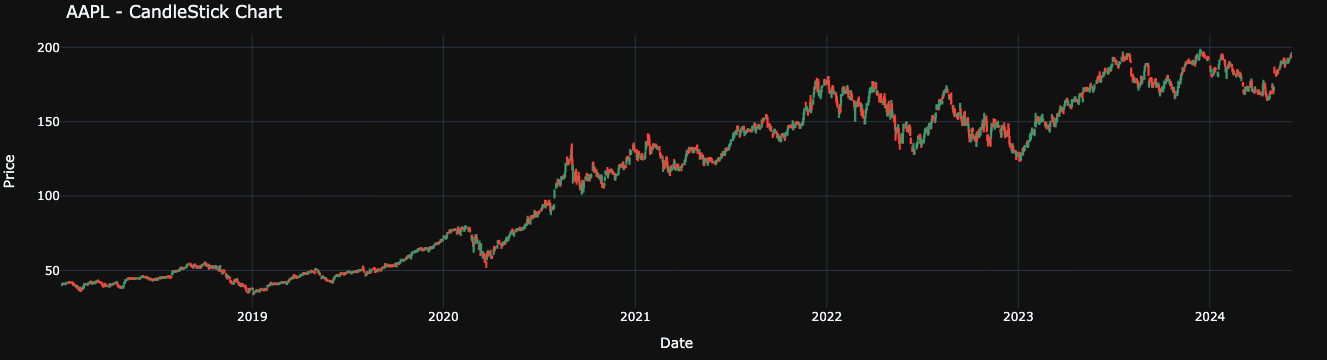

In [9]:
def set_padding(fig, padding_value):
    fig.update_layout(
        margin=dict(l=padding_value, r=padding_value, t=padding_value, b=padding_value)
    )

# Placeholder definitions
dt_breaks = ['2010-01-01', '2019-12-31']
TICKER = "AAPL"
TEMPLATE = "plotly_dark"

# Your original code with the modifications
fig = go.Figure(data=[go.Candlestick(x=data['Date'], open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'])])

# Sets customized padding
set_padding(fig,35)

# Remove dates without values
fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])

# Update Y & X axis labels
fig.update_yaxes(title_text='Price')
fig.update_xaxes(title_text='Date')
fig.update_layout(title=TICKER + ' - CandleStick Chart', xaxis_rangeslider_visible=False, height=500, template=TEMPLATE)

### Calculate the Relative Strength Index

In [10]:
# Calculate the RSI
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

### Signals

In [11]:
# Define signal criteria
def generate_signals(data):
    signals = []
    for i in range(len(data)):
        open_price = data.iloc[i]['Open']
        close_price = data.iloc[i]['Close']
        high_price = data.iloc[i]['High']
        low_price = data.iloc[i]['Low']
        rsi = data.iloc[i]['RSI']

        if open_price > close_price:  # Red candle
            body = abs(open_price - close_price)
            candle_length = abs(high_price - low_price)
            if body <= 0.4 * candle_length and rsi > 70:
                signals.append(('short', data.index[i], high_price, close_price))
        elif open_price < close_price:  # Green candle
            body = abs(open_price - close_price)
            candle_length = abs(high_price - low_price)
            if body <= 0.4 * candle_length and rsi < 30:
                signals.append(('long', data.index[i], low_price, close_price))
    
    return signals

In [12]:
signals = generate_signals(data)

### Risk Management

In [13]:
# Define risk-reward ratio and calculate take profit levels
def calculate_take_profits(signals, data):
    trades = []
    for signal in signals:
        if signal[0] == 'short':
            entry_date = signal[1]
            entry_price = signal[3]
            stop_loss = signal[2]
            risk = abs(entry_price - stop_loss)
            take_profit = entry_price - 2 * risk
            trades.append((entry_date, 'short', entry_price, stop_loss, take_profit))
        elif signal[0] == 'long':
            entry_date = signal[1]
            entry_price = signal[3]
            stop_loss = signal[2]
            risk = abs(entry_price - stop_loss)
            take_profit = entry_price + 2 * risk
            trades.append((entry_date, 'long', entry_price, stop_loss, take_profit))
    return trades

In [14]:
trades = calculate_take_profits(signals, data)

### Backtest

In [15]:
# Backtest the strategy
def backtest(trades, data):
    results = []
    for trade in trades:
        entry_date, trade_type, entry_price, stop_loss, take_profit = trade
        if trade_type == 'short':
            exit_price = data.loc[data.index > entry_date]['Low'].min()
            if exit_price <= take_profit:
                results.append((entry_date, 'short', entry_price, take_profit))
            elif data.loc[data.index > entry_date]['High'].max() >= stop_loss:
                exit_price = stop_loss
                results.append((entry_date, 'short', entry_price, exit_price))
        elif trade_type == 'long':
            exit_price = data.loc[data.index > entry_date]['High'].max()
            if exit_price >= take_profit:
                results.append((entry_date, 'long', entry_price, take_profit))
            elif data.loc[data.index > entry_date]['Low'].min() <= stop_loss:
                exit_price = stop_loss
                results.append((entry_date, 'long', entry_price, exit_price))
    return results

In [16]:
results = backtest(trades, data)

### Compute Returns

In [17]:
# Calculate returns
def calculate_returns(results):
    returns = []
    for result in results:
        entry_date, trade_type, entry_price, exit_price = result
        if trade_type == 'short':
            returns.append((exit_price - entry_price) / entry_price)
        elif trade_type == 'long':
            returns.append((exit_price - entry_price) / entry_price)
    return returns

In [18]:
returns = calculate_returns(results)

### Strategy Performance 

In [19]:
# Analyze the performance
cumulative_return = np.sum(returns)
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Assuming 252 trading days in a year
max_drawdown = np.max(np.maximum.accumulate(np.cumsum(returns)) - np.cumsum(returns))

print(f'Cumulative Return: {cumulative_return}')
print(f'Sharpe Ratio: {sharpe_ratio}')
print(f'Max Drawdown: {max_drawdown}')

Cumulative Return: -0.4327501044221762
Sharpe Ratio: -9.506533608314145
Max Drawdown: 0.46981884239039956


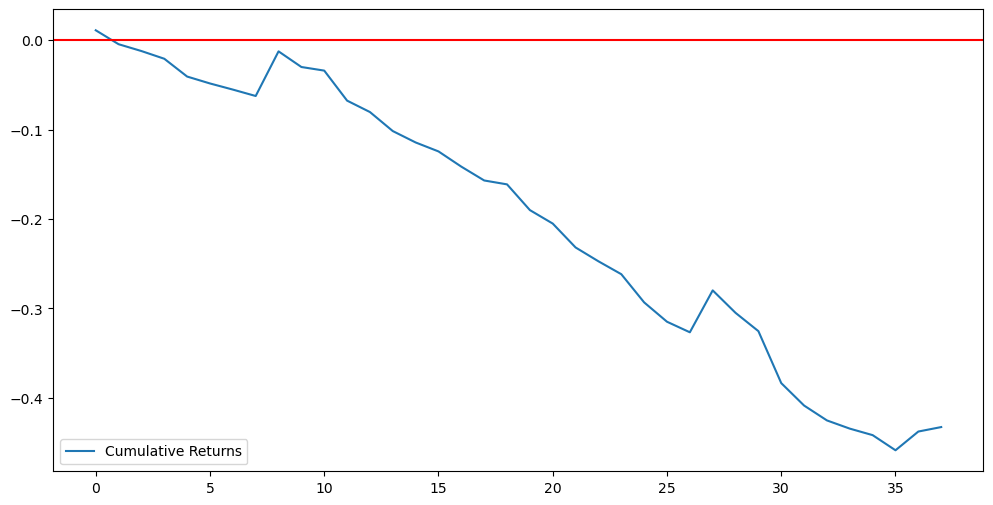

In [20]:
# Plot the cumulative return
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(returns), label='Cumulative Returns')
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
plt.show()